In [1]:
import os, pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('/Users/danieljoegasper/Downloads/Credit Card Defaulter Prediction.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,F,University,Married,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,Y
1,2,120000,F,University,Single,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,Y
2,3,90000,F,University,Single,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,N
3,4,50000,F,University,Married,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,N
4,5,50000,M,University,Married,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,N


In [3]:
# column name have spaces and remove them
df.rename(columns={"default ": "default"},inplace = True)

In [4]:
# We can See Dataset is imbalanced
df["default"].value_counts()
df.drop(['ID'],axis=1, inplace=True)
cat_features = df.select_dtypes(include='object')
cat_features.head()

,SEX,EDUCATION,MARRIAGE,default
0,F,University,Married,Y
1,F,University,Single,Y
2,F,University,Single,N
3,F,University,Married,N
4,M,University,Married,N


In [5]:
# encoding category columns
le = LabelEncoder()
encoded_num_df = pd.DataFrame()
for col in cat_features.columns:
    encoded_num_df[col] = le.fit_transform(cat_features[col])
encoded_num_df.head()
# final data
f_data = pd.concat([encoded_num_df,df.drop(['SEX','EDUCATION','MARRIAGE','default'],axis=1)],axis=1)
f_data.head()

,SEX,EDUCATION,MARRIAGE,default,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0,4,1,1,20000,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,0,4,3,1,120000,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,4,3,0,90000,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,4,1,0,50000,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,1,4,1,0,50000,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [6]:
# split data training and testing 
x_train,x_test,y_train,y_test = train_test_split(f_data.drop('default',axis=1),f_data['default'],test_size=0.2,random_state=42)

In [7]:
# scale data to 0 to 1 range 
sc = MinMaxScaler()
sc_x_train = pd.DataFrame(sc.fit_transform(x_train),columns=sc.feature_names_in_)
sc_x_test = pd.DataFrame(sc.fit_transform(x_test),columns=sc.feature_names_in_)

In [8]:
# scale data to 0 to 1 range 
sc = MinMaxScaler()
sc_x_train = pd.DataFrame(sc.fit_transform(x_train),columns=sc.feature_names_in_)
sc_x_test = pd.DataFrame(sc.fit_transform(x_test),columns=sc.feature_names_in_)
mutual_info_scores = mutual_info_classif(sc_x_train, y_train)
feature_scores_df = pd.DataFrame({'Feature': sc_x_train.columns, 'Mutual_Info_Score': mutual_info_scores})
feature_scores_df = feature_scores_df.sort_values(by='Mutual_Info_Score', ascending=False)

In [9]:
# choose 15 top features for model training
selected_features = feature_scores_df.head(15)['Feature'].tolist()
print("Selected Features:", selected_features)
# Select data with selected features
feature_selection_train = sc_x_train[selected_features]
feature_selection_test = sc_x_test[selected_features]

Selected Features: ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_5', 'PAY_4', 'PAY_6', 'PAY_AMT1', 'PAY_AMT3', 'LIMIT_BAL', 'PAY_AMT2', 'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT6', 'BILL_AMT1', 'BILL_AMT5']


In [10]:
# classification report with selected features using LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logreg = LogisticRegression(max_iter=200)
logreg.fit(feature_selection_train, y_train)
y_pred = logreg.predict(feature_selection_test)

logrepo= classification_report(y_test, y_pred)
print(logrepo)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4687
           1       0.67      0.30      0.42      1313

    accuracy                           0.81      6000
   macro avg       0.75      0.63      0.65      6000
weighted avg       0.80      0.81      0.79      6000



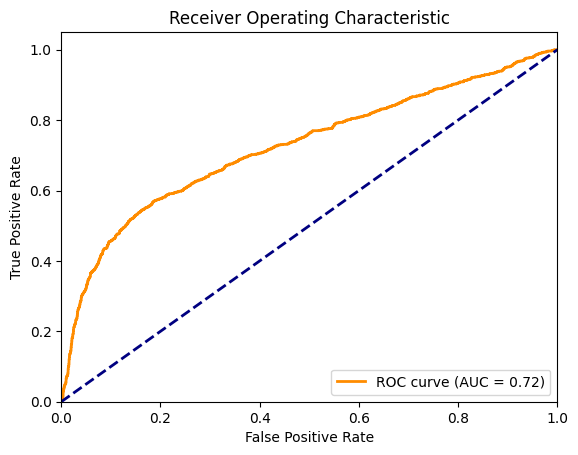

In [11]:
# Get predicted probabilities
y_pred_proba_log = logreg.predict_proba(feature_selection_test)[:, 1]
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_log)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

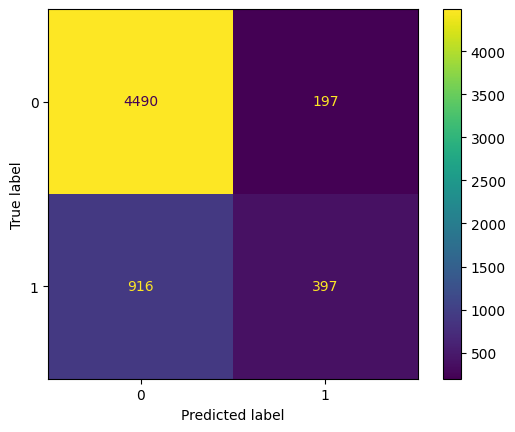

In [12]:
# the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

In [13]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(feature_selection_train, y_train)

# Predict on the test set
y_pred_dt = dt_classifier.predict(feature_selection_test)

# Print classification report
dtree= classification_report(y_test, y_pred_dt)
print(dtree)

              precision    recall  f1-score   support

           0       0.82      0.79      0.81      4687
           1       0.35      0.40      0.37      1313

    accuracy                           0.70      6000
   macro avg       0.59      0.60      0.59      6000
weighted avg       0.72      0.70      0.71      6000



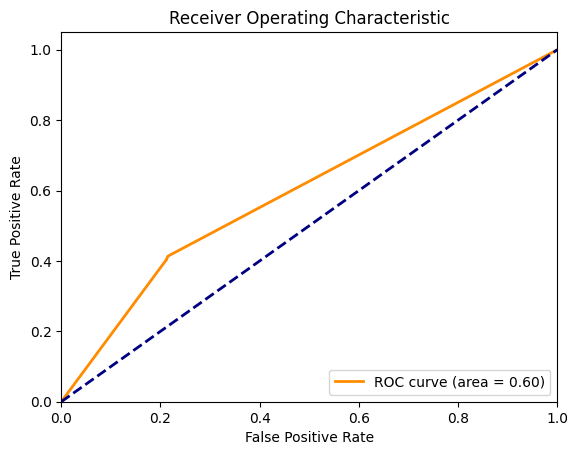

In [14]:
# Get predicted probabilities
y_pred_proba = dt_classifier.predict_proba(feature_selection_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

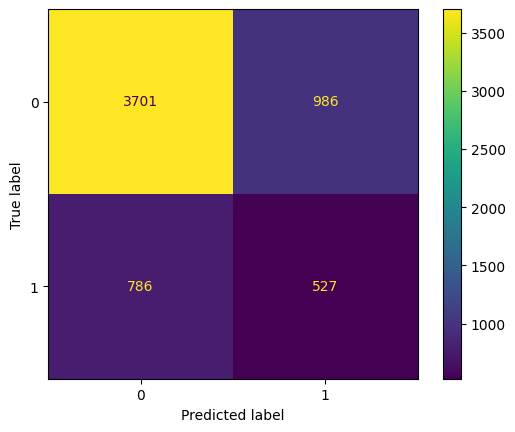

In [15]:
# Compute the confusion matrix
conf_matrix2 = confusion_matrix(y_test, y_pred_dt)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix2)
disp.plot()
plt.show()

In [16]:
import re
def parse_classification_report(report):
    # Split the report by lines
    lines = report.split('\n')
    parsed_data = []
    
    for line in lines[2:-3]:  # Skip headers and footers
        line_data = re.split(r'\s{2,}', line.strip())
        if len(line_data) < 5:
            continue
        class_name = line_data[0]
        precision = float(line_data[1])
        recall = float(line_data[2])
        f1_score = float(line_data[3])
        support = float(line_data[4])
        
        parsed_data.append({
            'class': class_name,
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score,
            'support': support
        })
    
    df = pd.DataFrame(parsed_data)
    return df

In [17]:
df1 = parse_classification_report(dtree)
df2 = parse_classification_report(logrepo)

In [18]:
# Add model names and overall accuracy
df1['model'] = 'Decision Tree'
df2['model'] = 'Logistic Regression'

# Concatenate the two dataframes
comparison_df = pd.concat([df1, df2])

# Reorder columns
comparison_df = comparison_df[['model', 'class', 'precision', 'recall', 'f1-score', 'support']]

# Display the comparison table
print(comparison_df)

                 model class  precision  recall  f1-score  support
0        Decision Tree     0       0.82    0.79      0.81   4687.0
1        Decision Tree     1       0.35    0.40      0.37   1313.0
0  Logistic Regression     0       0.83    0.96      0.89   4687.0
1  Logistic Regression     1       0.67    0.30      0.42   1313.0
